In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


column_name=['Var'] 

df1 = pd.read_csv('variants3725.csv',header=None).astype(object) #reading files 
df2 = pd.read_csv('labels3725.csv',header=None,usecols=range(8)).astype(float) #reading files 

In [2]:
display(df1.shape)
display(df2.shape)

(46894, 95)

(46894, 8)

In [50]:
def active(x,th=0.9):
    return (x[0:4]>th).any() and (x[4:8]>th).any()

In [51]:
Y37=df2.iloc[:,0:4]
Y25=df2.iloc[:,4:8]
Y25.columns=range(4)
yboth=Y37.idxmax(axis=1)*4+Y25.idxmax(axis=1)
ac_bool=df2.apply(active, axis=1)
yboth = yboth[ac_bool].astype(int)
df=df1.loc[ac_bool].assign(label=yboth).dropna()
df.shape

(14355, 96)

In [57]:
(unique, counts) = np.unique(yboth, return_counts=True)
h=np.asarray((unique, counts)).T
h=h[h[:,1]>200]
df=df.loc[df['label'].isin(h[:,0])]
df.shape

(14028, 96)

In [56]:
 unique

(13,)

In [61]:
print([base10to4(u) for u in unique])
print(counts)


['0', '1', '3', '10', '11', '12', '13', '21', '22', '23', '31', '32', '33']
[7152  848   16  539 4047   43  165   60   33  434    7    3 1008]


In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,label
0,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,11
1,2,0,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,5
4,2,3,0,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,11
6,2,3,1,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,11
9,2,3,2,1,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46791,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,3,1,1,1,2,4
46806,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,4
46818,2,3,2,0,1,3,1,2,2,0,...,1,1,1,1,1,0,1,1,1,5
46858,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,0


In [9]:
X=df1.replace([1, 2, 3, 0], ['T', 'G', 'C', 'A']) # replacing 1,2,3,0 with TGCA
df=df.assign(seq=X[X.columns[0:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1))
u1=df['label'].unique()
Nclasses=u1.shape[0]
df['label']=df['label'].replace(u1,range(Nclasses))
df

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,label,seq
0,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,0,GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
1,2,0,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,1,GAGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
4,2,3,0,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,0,GCAATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
6,2,3,1,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,0,GCTATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
9,2,3,2,1,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,0,GCGTTCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46791,2,3,2,0,1,3,0,2,2,0,...,1,1,1,3,1,1,1,2,5,GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
46806,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,5,GCGATCAGGAAGACCCTCGCGAAGAACCTGAAAGTACGACATTGCT...
46818,2,3,2,0,1,3,1,2,2,0,...,1,1,1,1,0,1,1,1,1,GCGATCTGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...
46858,2,3,2,0,1,3,0,2,2,0,...,1,1,1,1,1,1,1,1,4,GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACATCATTGCT...


In [10]:
u1

array([11,  5,  1, 15,  0,  4])

In [11]:
def getKmers(sequence, size=6): 
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)] #k-mer clustering

In [12]:
y=np.eye(u1.shape[0])[df['label']]
x=df.assign(words = df.apply(lambda x: getKmers(x['seq'],4), axis=1)) # applying k-mer 
x.shape

(9765, 98)

In [13]:
y.shape

(9765, 6)

In [14]:
x['words'].shape

(9765,)

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [16]:
texts = list(x['words']) #converting to list 
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

In [17]:
tokenizer = Tokenizer()        # tokenizing the words
tokenizer.fit_on_texts(texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(texts) 
max_length = max([len(s.split()) for s in texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print(X.shape)

[[ 14  19  15 ...   1   1   1]
 [ 25 175  15 ...   1   1   1]
 [176 136 194 ...   1   1   1]
 ...
 [ 14  19  15 ...  83  10  90]
 [ 14  19  15 ...   1   1   1]
 [ 14  19  15 ...   1   1   1]]
(9765, 92)


In [18]:
vocab_size = len(tokenizer.word_index)+1 #finding the number of unique words 
print(vocab_size) 
print(X.shape)

257
(9765, 92)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42) # splitting into train and test
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7812, 92) (7812, 6)
(1953, 92) (1953, 6)


In [20]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.layers import Layer, InputSpec


In [21]:
# Final model 
model = Sequential()
EMBEDDING_DIM = 100
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(10)) # LSTM
# model.add(Bidirectional(LSTM(10))) # Bi-LSTM
model.add(Dense(10, activation = 'relu')) # hidden layer 
model.add(Dense(Nclasses, activation = 'softmax')) # using softmax classifier with 4 classes 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 7030 samples, validate on 782 samples
Epoch 1/5
7030/7030 [==============================] - 6s 862us/step - loss: 1.5355 - accuracy: 0.3953 - val_loss: 1.2502 - val_accuracy: 0.5870
Epoch 2/5
7030/7030 [==============================] - 5s 777us/step - loss: 1.0891 - accuracy: 0.6225 - val_loss: 1.0038 - val_accuracy: 0.6905
Epoch 3/5
7030/7030 [==============================] - 5s 770us/step - loss: 0.9104 - accuracy: 0.7265 - val_loss: 0.8668 - val_accuracy: 0.7404
Epoch 4/5
7030/7030 [==============================] - 5s 775us/step - loss: 0.8402 - accuracy: 0.7488 - val_loss: 0.8385 - val_accuracy: 0.7417
Epoch 5/5
7030/7030 [==============================] - 5s 770us/step - loss: 0.8014 - accuracy: 0.7556 - val_loss: 0.7915 - val_accuracy: 0.7621


In [22]:
accr = model.evaluate(X_test,Y_test) # testing the accuracy of trained model 
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1953/1953 [==============================] - 1s 396us/step
Test set
  Loss: 0.800
  Accuracy: 0.755


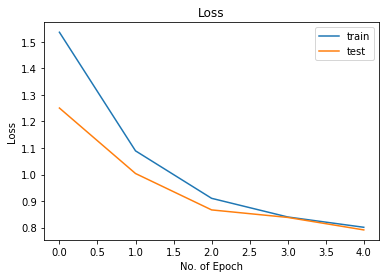

In [23]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.xlabel('No. of Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();



In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 92, 100)           25700     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
Total params: 30,316
Trainable params: 30,316
Non-trainable params: 0
_________________________________________________________________


In [58]:
def base10to4(n,base=4):
    converted_string, modstring = "", ""
    currentnum = n
    if not n:
        return "0"
    while currentnum:
        mod = currentnum % base
        currentnum = currentnum // base
        converted_string = chr(48 + mod + 7*(mod > 10)) + converted_string
    return converted_string

In [26]:
Y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in Y_predict ]
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

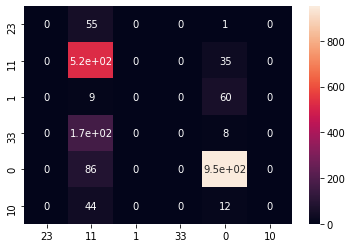

In [27]:
sns.heatmap(conf_mat,annot=True,xticklabels=np.vectorize(base10to4)(u1),yticklabels=np.vectorize(base10to4)(u1))

## comparing to naive dense network

In [28]:
model = Sequential()
EMBEDDING_DIM = 100
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(LSTM(10)) # Bi-LSTM
# model.add(Bidirectional(LSTM(10))) # Bi-LSTM
model.add(Flatten())
model.add(Dense(10, activation = 'relu')) # hidden layer 
model.add(Dense(Nclasses, activation = 'softmax')) # using softmax classifier with 4 classes 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


accr = model.evaluate(X_test,Y_test) # testing the accuracy of trained model 
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Train on 7030 samples, validate on 782 samples
Epoch 1/20
7030/7030 [==============================] - 1s 126us/step - loss: 1.4413 - accuracy: 0.5252 - val_loss: 1.1657 - val_accuracy: 0.5384
Epoch 2/20
7030/7030 [==============================] - 1s 109us/step - loss: 1.0426 - accuracy: 0.5541 - val_loss: 0.9920 - val_accuracy: 0.5460
Epoch 3/20
7030/7030 [==============================] - 1s 112us/step - loss: 0.9382 - accuracy: 0.5775 - val_loss: 0.9322 - val_accuracy: 0.5703
Epoch 4/20
7030/7030 [==============================] - 1s 118us/step - loss: 0.8834 - accuracy: 0.6083 - val_loss: 0.9119 - val_accuracy: 0.5601
Epoch 5/20
7030/7030 [==============================] - 1s 110us/step - loss: 0.8432 - accuracy: 0.6427 - val_loss: 0.8652 - val_accuracy: 0.6598
Epoch 6/20
7030/7030 [==============================] - 1s 107us/step - loss: 0.8088 - accuracy: 0.6844 - val_loss: 0.8364 - val_accuracy: 0.7008
Epoch 7/20
7030/7030 [==============================] - 1s 100us/step - loss:

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 92, 100)           25700     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                92010     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66        
Total params: 117,776
Trainable params: 117,776
Non-trainable params: 0
_________________________________________________________________


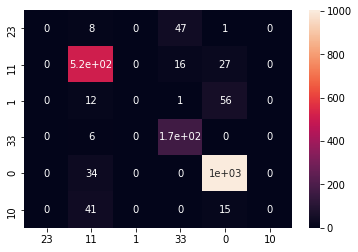

In [30]:
Y_predict = model.predict(X_test)
from sklearn.metrics import confusion_matrix
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in Y_predict ]
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
sns.heatmap(conf_mat,annot=True,xticklabels=np.vectorize(base10to4)(u1),yticklabels=np.vectorize(base10to4)(u1))

### try to reduce the number of parameters

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 92, 2)             514       
_________________________________________________________________
flatten_2 (Flatten)          (None, 184)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1110      
Total params: 1,624
Trainable params: 1,624
Non-trainable params: 0
_________________________________________________________________
Train on 7030 samples, validate on 782 samples
Epoch 1/200
7030/7030 [==============================] - 0s 58us/step - loss: 1.3943 - accuracy: 0.5259 - val_loss: 1.2542 - val_accuracy: 0.5345
Epoch 2/200
7030/7030 [==============================] - 0s 27us/step - loss: 1.2101 - accuracy: 0.5316 - val_loss: 1.1955 - val_accuracy: 0.5345
Epoch 3/200
7030/7030 [====================

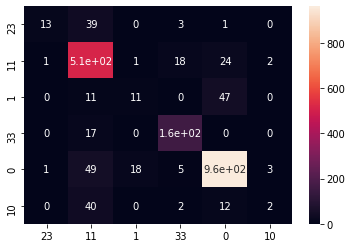

In [31]:
model = Sequential()
EMBEDDING_DIM = 2
model.add(Embedding(257, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(LSTM(10)) # Bi-LSTM
# model.add(Bidirectional(LSTM(10))) # Bi-LSTM
model.add(Flatten())
# model.add(Dense(10, activation = 'relu')) # hidden layer 
model.add(Dense(Nclasses, activation = 'softmax')) # using softmax classifier with 4 classes 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 200
batch_size = 64

model.summary()

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


accr = model.evaluate(X_test,Y_test) # testing the accuracy of trained model 
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in Y_predict ]
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
sns.heatmap(conf_mat,annot=True,xticklabels=np.vectorize(base10to4)(u1),yticklabels=np.vectorize(base10to4)(u1))

In [32]:
Em=model.layers[0].get_weights()[0]
W=model.layers[2].get_weights()[0]

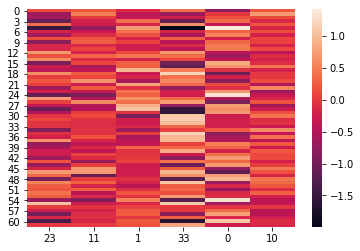

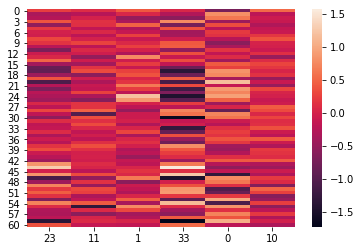

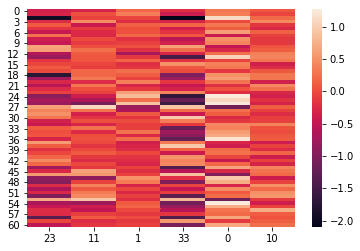

In [33]:
sns.heatmap(W[0::3,:],xticklabels=np.vectorize(base10to4)(u1))
plt.figure()
sns.heatmap(W[1::3,:],xticklabels=np.vectorize(base10to4)(u1))
plt.figure()
sns.heatmap(W[2::3,:],xticklabels=np.vectorize(base10to4)(u1))

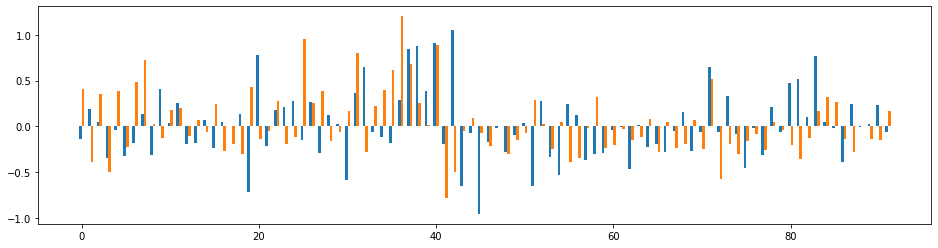

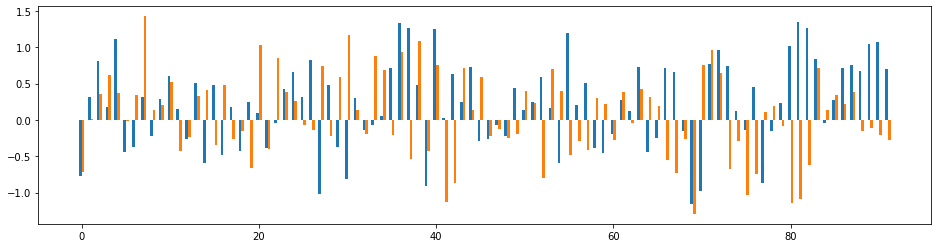

In [34]:
fig, ax = plt.subplots(figsize=(16,4))
width=0.3;x=np.arange(W.shape[0]/2)
rects1 = ax.bar(x - width/2, W[0::2,2], width)
rects2 = ax.bar(x + width/2, W[1::2,2], width)

fig, ax = plt.subplots(figsize=(16,4))
width=0.3;x=np.arange(W.shape[0]/2)
rects1 = ax.bar(x - width/2, W[0::2,4], width)
rects2 = ax.bar(x + width/2, W[1::2,4], width)


In [35]:
embeddings = model.layers[0].get_weights()[0]
words_embeddings = {w: embeddings[idx] for w, idx in tokenizer.word_index.items()}

In [36]:
print(embeddings.shape)
print(W.shape)

(257, 2)
(184, 6)


In [37]:
# converting back to words - reverse tokenizer 

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)


In [38]:
# getting weight matrix -  {a1,c1,g1,t1,a2,c2........}
def value(j,p):
    if j==0 and p=='a':
        index=0
    elif j==0 and p=='c':
        index=1
    elif j==0 and p=='g':
        index=2
    elif j==0 and p=='t':
        index=3
    elif j==1 and p=='a':
        index=4
    elif j==1 and p=='c':
        index=5
    elif j==1 and p=='g':
        index=6
    elif j==1 and p=='t':
        index=7
    elif j==2 and p=='a':
        index=8
    elif j==2 and p=='c':
        index=9
    elif j==2 and p=='g':
        index=10
    elif j==2 and p=='t':
        index=11
    elif j==3 and p=='a':
        index=12
    elif j==3 and p=='c':
        index=13
    elif j==3 and p=='g':
        index=14
    elif j==3 and p=='t':
        index=15
    return index
    

In [39]:
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge , Lasso

In [40]:
# ridge regression
def regression(X,y):
    W= np.zeros((16,92))
    for i in range(92):
        rr = Ridge(alpha=1)
        rr.fit(X[i], y[:,i])
        W[:,i]=rr.coef_
    return W
    

In [41]:
import logomaker as lm

In [42]:
def todf(W):
    W=np.reshape(np.transpose(W), (368,4)) 
    Wdf=pd.DataFrame({'A': W[:, 0], 'C': W[:, 1],'G': W[:, 2], 'T': W[:, 3]})
    return Wdf
    

In [43]:
def get_score(W):
    P=np.zeros(X.shape)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            q=np.transpose(np.reshape(W,(92,2)))
            
            P[i][j]=np.dot(embeddings[int(X[i][j])],q[:,j])
    return P
        

In [44]:
def get_eq(df):
    
    Xf=np.zeros((X.shape[1],X.shape[0],16))
    for k in range(X.shape[1]):
        for i in range(X.shape[0]):
            for j in range(4):
                p=df[k][i][j]
                index=value(j,p)
                Xf[k][i][index]=1
    return Xf

In [45]:
Df_seq = list(map(sequence_to_text, X))
Df = pd.DataFrame(Df_seq)
Xf=get_eq(Df)
Xf.shape

(92, 9765, 16)

In [46]:
def word_wt(W):
    DF=pd.DataFrame()
    for n in range(92):
        u=pd.unique(Df[[n]].values.ravel('K'))
        wt=np.zeros(u.shape[0])
        q=np.transpose(np.reshape(W,(92,2)))
        for i in range(u.shape[0]):
            wt[i]=np.dot(embeddings[tokenizer.word_index[u[i]]],q[:,n])
        Wt_log=np.log(wt-np.min(wt, axis=0)+1)
        df = pd.DataFrame()
        df['words']=u
        df['score']=Wt_log
        dfsort = df.sort_values(by ='score',ascending=False,ignore_index=True )
        DF=pd.concat([DF,dfsort],axis=1, ignore_index=True)
    return DF

In [47]:
for i in range(6):
    
    locals()["Wf" + str(i)]= get_score(W[:,i])
    
    locals()["yf" + str(i)]=np.log(locals()["Wf" + str(i)]-np.min(locals()["Wf" + str(i)], axis=0)+1)
    
    locals()["R" + str(i)]=regression(Xf,locals()["yf" + str(i)])
    
    locals()["R" + str(i)]=todf(locals()["R" + str(i)])



In [1]:
Word_wt1


NameError: name 'Word_wt1' is not defined

In [48]:
for i in range(6):
    
    locals()["Word_wt" + str(i)]=word_wt(W[:,i])
    

In [53]:
Word_wt0.to_csv(r'C:\Users\pradh\W0.csv', index=False)
# Word_wt1.to_csv(r'C:\Users\pradh\W1.csv', index=False)
# Word_wt2.to_csv(r'C:\Users\pradh\W2.csv', index=False)
# Word_wt3.to_csv(r'C:\Users\pradh\W3.csv', index=False)
# Word_wt4.to_csv(r'C:\Users\pradh\W4.csv', index=False)
# Word_wt5.to_csv(r'C:\Users\pradh\W5.csv', index=False)

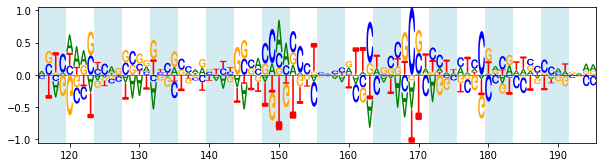

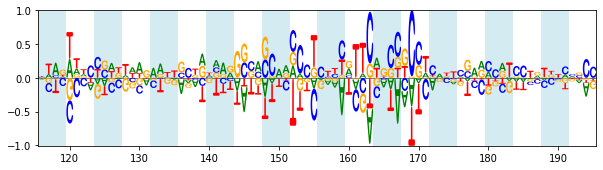

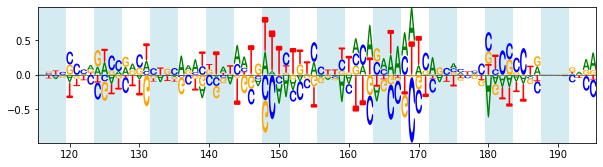

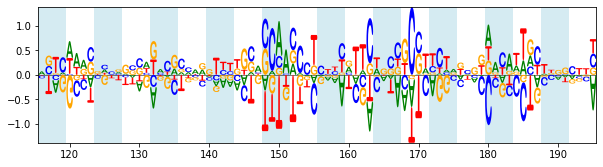

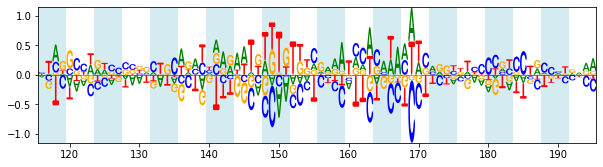

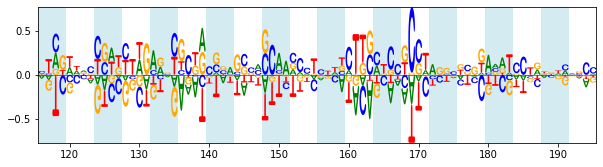

In [50]:
i=30
n=20
for c in range(6):
    
    logo = lm.Logo(locals()["R" + str(c)][(i-1)*4:(i+n-1)*4], font_name = 'Arial Rounded MT Bold')

    for j in range(i, (i+n-1), 2):
        logo.highlight_position_range((j-1)*4,j*4-1,alpha=0.5,color='lightblue')


In [51]:
import matplotlib.pyplot as plt

In [10]:
import scipy.io as sio
mat_contents = sio.loadmat('/Users/omkarpradhan/PhD/RNA-GAT/sortseq_PL2017_semiraw.mat')
mn=mat_contents['repression_log2fold']
er=mat_contents['errorest_log2fold']

In [12]:
mn.shape

(149309, 6)

In [14]:
er.shape

(149309, 6)

In [16]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'errorest_log2fold', 'mutation_array', 'num_sorted_cells', 'repression_log2fold', 'sampleID', 'srna_variant_sequence'])

In [18]:
mut=mat_contents['mutation_array']

In [20]:
mut.shape

(149309, 968)

In [22]:
mn[0]

array([1.18538539, 1.14002576, 1.12299712, 1.00198221, 0.91281912,
       0.72304984])

In [77]:
ix100=mat_contents['num_sorted_cells'][:,0]>20

In [78]:
ix100.shape

(149309,)

In [79]:
mn=mat_contents['repression_log2fold'][:,0][ix100]

In [80]:
mn.shape

(41419,)

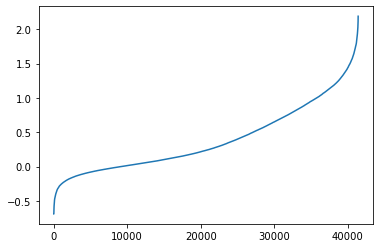

In [81]:
plt.plot(np.sort(mn))

In [82]:
mn[0]

1.1853853913342496

In [83]:
print(sum(mn>-1.7+2*mn[0]))
sum(mn<+1.5-mn[0])

11068


22978

In [84]:
seq=mat_contents['srna_variant_sequence']

In [96]:
seq[0][149308]

array(['GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCTCACATTGCTTCCAGTATTACTTTGCCAGCCGTGTGCTTTCTTTTTTTTT'],
      dtype='<U95')

In [92]:
seq.shape

(1, 149309)